# Ретроспективный анализ рынка компьютерных игр <a id="начало"></a>

## Оглавление <a id="оглавление"></a>

* [Описание проекта](#описание)
* [Шаг 1. Изучение данных](#Шаг_1)
* [Шаг 2. Предобработка данных](#Шаг_2)
* [Шаг 3. Исследовательский анализ данных (EDA)](#Шаг_3)
* [Шаг 4. Портреты пользователей в разных регионах](#Шаг_4)
* [Шаг 5. Проверка гипотез](#Шаг_5)
* [Шаг 6. Результаты исследования](#Шаг_6)

## Описание проекта <a id="описание"></a>

**Заказчик:** Интернет-магазин «Стримчик»

**Что исследуем:** рынок компьютерных игр за 2016 год

**Цель заказчика:** Увеличить прибыль от продаж игр за счет правильно спланированной рекламной кампании

**Задачи**: Выявить закономерности, определяющие успешность игры; определить потенциально популярный продукт

**Данные:** Исторические данные за 2016 год об играх: продажи, оценки пользователей и экспертов, жанры и платформы

**Важные замечания:** 
1. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков» <br>
<br>
2. Данные за 2016 год могут быть неполными<br>
<br>
3. В столбцах с рейтингом встречается аббревиатура 'tbd' 

## Шаг 1. Изучение данных <a id="Шаг_1"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion1)

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math as mt

plt.style.use('seaborn')

import warnings # возникали предупреждения, но код работал
warnings.filterwarnings('ignore') # решил отключить эти предупреждения

pd.options.display.float_format = '{: .2f}'.format

df = pd.read_csv('/datasets/games.csv')

In [2]:
# изучаем данные
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,nan,NaN,NaN
6,New Super Mario Bros.,DS,2006.00,Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,2006.00,Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,nan,NaN,NaN


In [3]:
#находим пропущенные значения
missing_values = df.isnull().sum()[df.isnull().sum() > 0]
missing_values

Name                  2
Year_of_Release     269
Genre                 2
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

### Описание данных
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Описание рейтинга ESRB

Рейтинг игр ESRB основан на их содержании аналогично рейтинговым системам кинофильмов. Рейтинг игры напечатан на упаковке, содержится в её рекламе и указан на сайте игры. Компании не обязаны предоставлять игру на определение рейтинга до начала официальных продаж, так как её содержимое может значительно измениться в ходе разработки.

Рейтинг состоит из двух частей: знака рейтинга и краткого описания содержимого. Знак рейтинга обычно располагается в нижнем левом или правом углу на лицевой стороне упаковки и определяет наиболее подходящую возрастную категорию для игры. Описание содержимого располагается на обратной стороне коробки, обычно в нижнем левом или правом углу и перечисляет некоторые элементы содержания игры.

* «EC» («Early childhood») — «Для детей младшего возраста»
* «E» («Everyone») — «Для всех»
* Year_of_Release — год выпуска
* «E10+» («Everyone 10 and older»)
* «T» («Teen») — «Подросткам»
* «M» («Mature») — «Для взрослых»
* «AO» («Adults Only 18+») — «Только для взрослых»
* «RP» («Rating Pending») — «Рейтинг ожидается»

В таблице есть две игры с пропущенными именами и жанрами. <br>
Эти пропуски не составляют большой доли от всех данных и восстановить их не удастся. Поэтому удалим их. <br>
<br>
Также пропуски есть в столбце с годом выпуска игры. Посмотрим, сколько их.

In [4]:
print('Доля игр без установленного года релиза:', round(len(df.query('Year_of_Release.isna()')) / len(df), 2))

Доля игр без установленного года релиза: 0.02


In [5]:
len(df.query('Year_of_Release.isna()'))

269

Доля таких пропусков совсем небольшая. <br>
Так как данные из этого столбца будут нужны для анализа, удалим пропуски в этом столбце.

In [6]:
# изучим срез данных со значением tbd в столбце User_scores

df.query('User_Score == "tbd"').info()
df.query('User_Score == "tbd"').sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2424 entries, 119 to 16706
Data columns (total 11 columns):
Name               2424 non-null object
Platform           2424 non-null object
Year_of_Release    2376 non-null float64
Genre              2424 non-null object
NA_sales           2424 non-null float64
EU_sales           2424 non-null float64
JP_sales           2424 non-null float64
Other_sales        2424 non-null float64
Critic_Score       1082 non-null float64
User_Score         2424 non-null object
Rating             2374 non-null object
dtypes: float64(6), object(5)
memory usage: 227.2+ KB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
8826,NBA ShootOut 2001,PS2,2001.00,Sports,0.07,0.06,0.00,0.02,54.00,tbd,E
9938,Brunswick Pro Bowling,3DS,2011.00,Sports,0.11,0.00,0.00,0.01,nan,tbd,E
11131,NFL Blitz 20-02,GC,2002.00,Sports,0.07,0.02,0.00,0.00,77.00,tbd,E
1367,Hello Kitty Party,DS,2007.00,Misc,0.78,0.51,0.00,0.12,nan,tbd,E
13847,Monster Band,DS,2008.00,Misc,0.04,0.00,0.00,0.00,nan,tbd,E


In [7]:
# проверим, на каких платформах выходили игры
df.query('User_Score == "tbd"').Platform.value_counts()

DS      756
Wii     440
GBA     262
PS2     240
XB      150
PSP     123
GC      103
PS3      87
X360     84
3DS      56
PC       49
PS       45
XOne     11
PSV       7
PS4       6
WiiU      5
Name: Platform, dtype: int64

Отметка tbd в столбце с оценкой пользователей означает "To be Determined" (еще не определен). <br>
Значит по каким-то причинам пользователи еще не оценили эти игры <br>
Большинство игр без оценки относятся либо к менее распространенным платформам (Nintendo DS, Wii, GBA), либо к старым. <br>
Также у игр с оценкой "tbd" чащего всего маленькие объемы продаж, а значит и сами игры тоже мало распространены.<br>
<br>
Значения 'tbd' нужно заменить на пропуски и изменить тип данных на float, чтобы мы могли использовать столбец для рассчетов.

In [8]:
# изучим пропуски в столбце Rating

df.query('Rating.isna()').sample(20)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
10938,Hakuouki: Zuisouroku Portable,PSP,2010.00,Adventure,0.00,0.00,0.09,0.00,nan,NaN,NaN
9361,Dragon Age Origins: Awakening,PC,2010.00,Role-Playing,0.01,0.10,0.00,0.02,nan,NaN,NaN
7959,Little Battlers eXperience W,PSP,2012.00,Role-Playing,0.00,0.00,0.19,0.00,nan,NaN,NaN
279,Teenage Mutant Ninja Turtles,NES,1989.00,Action,3.38,0.44,0.31,0.04,nan,NaN,NaN
4603,Jikkyou Powerful Pro Yakyuu 6,N64,1999.00,Sports,0.00,0.00,0.39,0.03,nan,NaN,NaN
4834,Avatar: The Game,DS,2009.00,Action,0.18,0.18,0.00,0.04,nan,NaN,NaN
13685,Amnesia,PSP,2011.00,Adventure,0.00,0.00,0.04,0.00,nan,NaN,NaN
10362,Sakura Wars,DC,2000.00,Adventure,0.00,0.00,0.11,0.00,nan,NaN,NaN
11557,Sengoku Musou 3: Moushouden,Wii,2011.00,Action,0.00,0.00,0.08,0.00,nan,NaN,NaN
4338,Mobile Suit Gundam,PS,1995.00,Action,0.00,0.00,0.42,0.03,nan,NaN,NaN


In [9]:
# посмотрим, какую долю занимают игры без рейтинга ESRB
print('Доля игр с неустановленным рейтингом:', round(len(df.query('Rating.isna()')) / len(df), 2))

Доля игр с неустановленным рейтингом: 0.4


Удалять почти половину всех данных не стоит. <br>
Лучше заменим пропуски в этом столбце на на аббревиатуру 'ND' (Not Determined), что будет означать, что рейтинг у игры не установлен.

In [10]:
# напоследок проверим наличие полных дубликатов в таблице
df.duplicated().sum()

0

Дубликатов нет.

### Выводы <a id="conclusion1"></a>

Всего у двух игр отсутствуют название и жанр. Удалим эти пропуски, так как нам важны и жанр и название игры.<br>

Также есть много пропусков в столбцах с оценкой от пользователей и критиков. <br>
Вероятно, оценки отсутствуют из-за малой популярности игр (низкий уровень продаж, узкий сегмент платформ) или из-за того, что игры вышли недавно. В разных случаях могут быть разные причины.<br>
Заполнять такие пропуски мы не будем, так как точно рассчитать рейтинг игры на основе представленных данных невозможно. <br>

Также есть пропуски в столбце с возрастным рейтингом. Их мы заменим на аббревиатуру ND, т.е. "рейтинг не определен". <br>

Пропуски в столбце с годом выпуска игры заполнять не будем и просто удалим их, так как они не составляют большой доли всех данных. <br>

Значения 'tbd' в столбце с оценкой пользователей заменим на пропуски, так как это значение говорит об отсутствии оценки. <br>

Типа данных заменим так:
* на int в столбце с годом релиза
* на float в столбце с оценкой пользователей



***

## Шаг 2. Предобработка данных <a id="Шаг_2"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion2)

Чек-лист чтобы ничего не забыть:
- [x] названия столбцов заменены
- [x] типы данных изменены
- [x] пропуски обработаны
- [x] описаны возможные причины возникновения пропусков (в шаге 1)
- [x] значение 'tbd' в столбцах с рейтингом описано (в шаге 1) и обработано
- [x] посчитаны и записаны в отдельный столбец суммарные продажи со всех регионов

### Замена названий столбцов

[В начало шага](#Шаг_2)

In [11]:
# приведем название всех столбцов к написанию в нижнем регистре
df.columns = df.columns.str.lower()

# проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Названия столбцов теперь написаны верно.

### Обработка пропусков

[В начало шага](#Шаг_2)

In [12]:
# Замена tbd в столбце с оценкой пользователей

df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

# проверим
df.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


В столбце больше нет строковых значений 'tbd', а значит можно заменить тип данных этого столбца на float.

In [13]:
# удалим строки с пропусками в столбцах с названием, жанром и годов выпуска игры
df.dropna(subset = ['name','platform','year_of_release'], inplace = True)

#проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [14]:
# # заменим пропуски в столбце rating на аббревиатуры ND
df.loc[df['rating'].isna(), 'rating'] = 'ND'

# # проверяем
display(df.query('rating == "ND"'))
display(df.query('rating.isna()'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,ND
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,ND
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,nan,NaN,ND
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,nan,NaN,ND
10,Nintendogs,DS,2005.00,Simulation,9.05,10.95,1.93,2.74,nan,NaN,ND
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,nan,NaN,ND
16711,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,nan,NaN,ND
16712,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,nan,NaN,ND
16713,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,nan,NaN,ND


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Замена прошла успешно и пропусков в столбце 'rating' больше нет.

### Замена типов данных

[В начало шага](#Шаг_2)

In [15]:
df.user_score = df.user_score.astype(float)
df.year_of_release = df.year_of_release.astype(int)


# проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             16444 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Типы данных изменены верно.

### Анализ и обработка нелогичных значений

[В начало шага](#Шаг_2)

In [16]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16444.00,16444.00,16444.00,16444.00,16444.00,7983.00,7463.00
mean,2006.49,0.26,0.15,0.08,0.05,68.99,7.13
std,5.88,0.82,0.51,0.31,0.19,13.92,1.50
min,1980.00,0.00,0.00,0.00,0.00,13.00,0.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00,6.40
50%,2007.00,0.08,0.02,0.00,0.01,71.00,7.50
75%,2010.00,0.24,0.11,0.04,0.03,79.00,8.20
max,2016.00,41.36,28.96,10.22,10.57,98.00,9.70


Нелогичных значений (слишком больших или слишком маленьких, а также неадекватных) в таблице не обнаружено.

### Рассчет суммарных продаж игр в регионах
[В начало шага](#Шаг_2)

In [17]:
# создадим новый столбец, в котором сохраним сумму продаж во всех регионах
df['global_sales'] = (df.na_sales
                  + df.eu_sales
                  + df.jp_sales
                  + df.other_sales)

#проверем
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,nan,ND,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,nan,ND,31.38


### Итоги предобработки данных <a id="conclusion2"></a>
[В начало шага](#Шаг_2)

* Привели написание названий столбцов к нижнему регистру
* Удалили строки с пропущенными значениями в столбцах с названием, жанром и годом выпуска игры 
* В столбце с оценкой пользователей заменили оценку 'tbd' на пропуски, т.к. над этим столбцом нужно будет производить вычисления и он должен быть в численном типе
* Заменили пропуски в столбце с рейтингом ESRB на аббревиатуру "ND" ("не определен"), т.к. этот столбец будет важен для ответа на некоторые вопросы заказчика
* Заменили типы данных в столбцах с годом выпуска игры и оценкой пользователей на целочисленный и вещественный соответственно.

***

## Шаг 3. Исследовательский анализ данных (EDA)  <a id="Шаг_3"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion3)

Чек-лист:
- [x] Определить, сколько игр выпускалось в разные годы
- [x] Определить, важны ли данные за все периоды
- [x] Изучить, как менялись продажи по платформам: построить графики распределения продаж по годам для каждой платформы и определить платформы с наибольшими суммарными продажами
- [x] Определить, за какой характерный срок появляются новые и исчезают старые платформы
- [x] Определить, данные за какой период будут актуальными для анализа и построения прогноза на следующий год
- [x] Определить, какие платформы лидируют по продажам, растут или падают. Выбрать потенциально прибыльные платформы
- [x] Построить график "ящик с усами" по глобальным продажам игр в разбивке по платформам, описать результат
- [x] Определить, как отзывы пользователей и критиков влияют на продажи внутри одной популярной платформы: построить диаграмму рассеяния для отзывов и продаж; посчитать корреляцию для отзывов и продаж
- [x] Соотнести выводы с продажами игр на других платформах
- [x] Изучить общее распределение игр по жанрам: определить и описать самые прибыльные жанры; определить, выделяются ли жанры с высокими и низкими продажами

### Определяем актуальный период для анализа данных

#### Определяем кол-во выпущенных игр за каждый год

,number_of_games
year_of_release,
2008,1427
2009,1426
2010,1255
2007,1197
2011,1136
2006,1006
2005,939
2002,829
2003,775


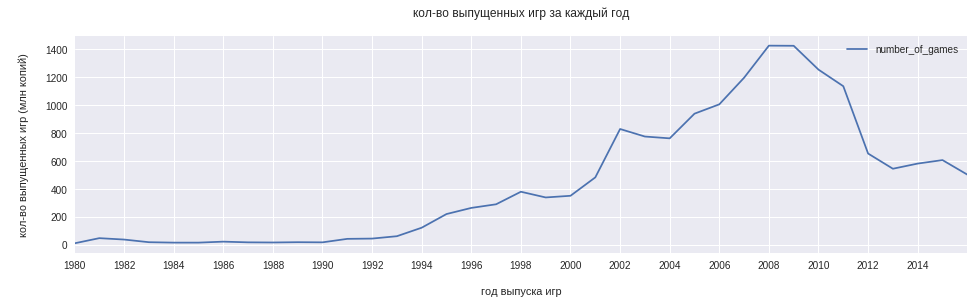

In [18]:
# сгруппируем датасет по году выпуска игры и посчитаем кол-во выпущенных игр
years_df = df.groupby('year_of_release')[['name']].count()
years_df.columns = ['number_of_games']

display(years_df.sort_values(by = 'number_of_games', ascending = False).head(15))

years_df.plot(title = 'кол-во выпущенных игр за каждый год' + "\n",
              figsize = (16, 4), grid = True
             )
plt.xlabel("\n" + 'год выпуска игр')
plt.ylabel("\n"+ "кол-во выпущенных игр (млн копий)" + "\n")
plt.xticks(np.arange(1980, 2016, step=2))
plt.show()

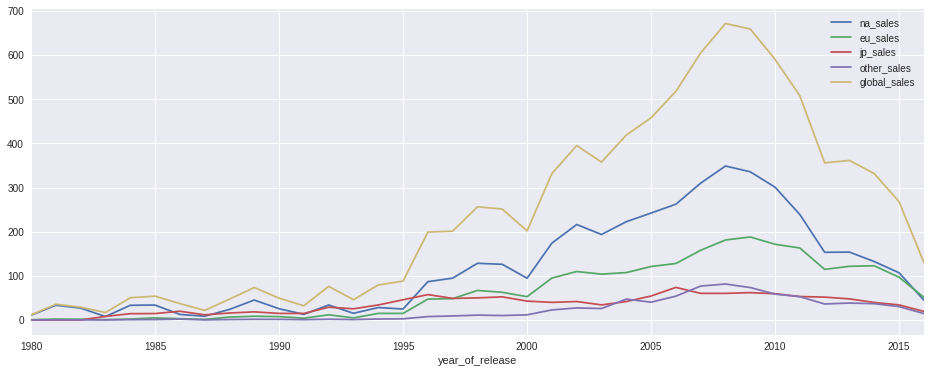

In [44]:
# посмотрим на продажи в регионах
sales_df = df[[x for x in df.columns if 'sales' in x] + ['year_of_release']]
sales_df.groupby('year_of_release').sum().plot(figsize = (16, 6))
plt.show()

Больше всего игр выходило в 2008 году. <br>
В целом можно сказать, что за период с 2005 по 2010 выпускалось много игр. <br>
А вот после 2011 года количество выпускаемых в год игр сократилось: среднее кол-во игр за год в период с 2012 по 2016 год значительно меньше, чем среднее кол-во игр за год в период с 2005-2010 и даже в период 2002-2005.

Бурный рост и последующий спад можно связать с ростом экономики и последующей глобальной рецессией, возникшей из-за лопнувшего финансового пузырая на рынке ценных бумаг в США в 2008 году. Рост инфляции привел к снижению уровня потребления, т.е. к снижению объемов продаж во многих секторах экономики.

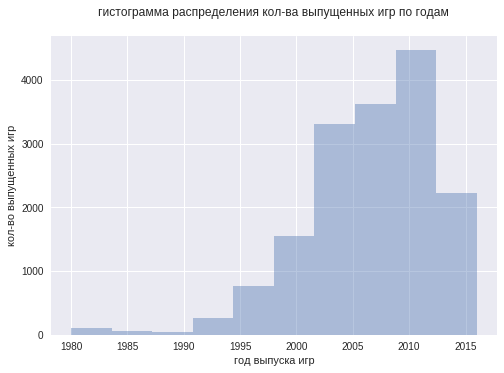

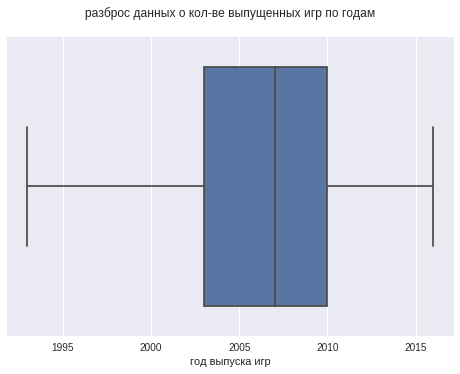

In [20]:
# построим гистограмму распределения
sns.distplot(df.year_of_release, kde=False, bins = 10)
plt.title('гистограмма распределения кол-ва выпущенных игр по годам' + "\n")
plt.xlabel('год выпуска игр')
plt.ylabel("кол-во выпущенных игр")
plt.show()

# построим график размаха значений
sns.boxplot(df.year_of_release, showfliers = False)
plt.title('разброс данных о кол-ве выпущенных игр по годам' + "\n")
plt.xlabel('год выпуска игр')
plt.show()

Практически все данные сосредоточены в периоде с 1993 по 2016 годы. <br>
75% данных находятся в периоде с 2003 по 2016 год. <br>

Прежде, чем определить период, стоит изучить частоту появления платформ и их жизненный цикл. <br>
Это поможет определить период более точно.

#### Определяем популярные платформы и их жизненный цикл

In [21]:
#изучим, игры на каких платформах самые продаваемые во всех трех регионах

top_platforms = (df
                    .groupby(by = 'platform')['global_sales']
                    .sum()
                    .sort_values(ascending = False)
                    .head(10)
                    .reset_index()
                )

top_platforms

,platform,global_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


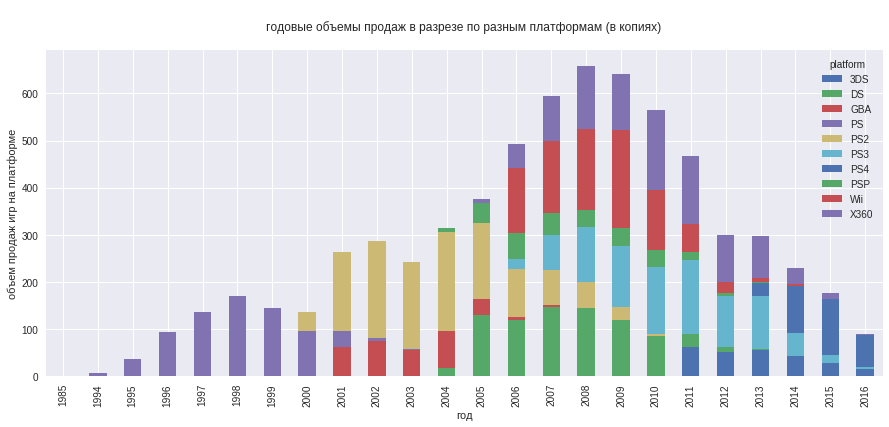

In [22]:
# сохраним список этих платформ
top_platforms_list = list(top_platforms['platform'])
top_platforms_list

# и построим график распределения продаж на этих платформах от года к году
(
    (
    df
     .query('platform.isin(@top_platforms_list)')
     .pivot_table(
                 index = 'year_of_release',
                 columns = 'platform',
                 values = 'global_sales',
                 aggfunc = 'sum'
                 )
    )
    .plot(kind = 'bar',
       stacked = True,
       figsize = (15, 6))
)
plt.title("\n" + 'годовые объемы продаж в разрезе по разным платформам (в копиях)' + "\n")
plt.xlabel('год')
plt.ylabel("объем продаж игр на платформе")
plt.show()

На примере 10 платформ видно, что средний срок жизни одной платформы — 10 лет. <br>
Чем ближе возраст платформы к 10 годам, тем ниже объем и доля продаж. <br>
Объем продаж значительно падает уже после 6-7 лет после выхода платформы. <br>
Вероятно, это связано с тем, что спустя именно столько лет появляются новые платформы.

Это хорошо видно на графике:
* спустя 6 лет после выхода PS(красный, 1994), появлятеся PS2 (фиолетовый, 2000)
* спустя 4 года после выхода PS2 появляется Nintendo DS(оранжевый, 2004)
* спустя 5 и 6 лет — Xbox 360, Wii и PS3 (бирюзовый 2005, светло-зеленый и коричневый 2006). <br>

Новые платформы от Nintentdo, Sony и Microsoft выходят закономерно:
* Nintendo 3DS(голубой, 2011) спустя 7 лет после запуска DS(оранжевый, 2004)
* Sony PS4 (розовый, 2013) спустя 7 лет после запуска PS3 (коричневый, 2006)
* Xbox one выходит спустя 8 лет после выхода Xbox 360 (бирюзовый, 2005; на графике не видно из-за малого объема продаж на старте)

Следует взять период с 2013 года, чтобы проанализировать данные по платформам нового поколения, которые будут актуальны до 2020-2021 годов.

In [23]:
# Создадим срез данных с актуальным периодом

df_fresh = df.query('year_of_release >= 2013')

# проверим, срез должен составлять не более 20% от изначального датасета
display(df_fresh.info())

print ('Доля нового датасета от старого:', round((len(df_fresh) / len(df)), 2))

print('Минимальный год релиза в новом датасете:',df_fresh.year_of_release.min())

# все верно

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
name               2233 non-null object
platform           2233 non-null object
year_of_release    2233 non-null int64
genre              2233 non-null object
na_sales           2233 non-null float64
eu_sales           2233 non-null float64
jp_sales           2233 non-null float64
other_sales        2233 non-null float64
critic_score       991 non-null float64
user_score         1192 non-null float64
rating             2233 non-null object
global_sales       2233 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 226.8+ KB


None

Доля нового датасета от старого: 0.14
Минимальный год релиза в новом датасете: 2013


### Промежуточный вывод об актуальной периоде данных для анализа <a id="conclusion3"></a>
[В начало шага](#Шаг_3) <br>

Для последующего анализа возьмем данные за период с 2013 по 2016. <br>
Новые платформы выходят каждые 6-7 лет и последнее поколение популярных платформ вышло именно в 2013 году.<br>
Так мы проанализируем действительно актуальные данные.
***

### Определяем потенциально прибыльные платформы

Потенциально прибыльные платформы — те, у которых от года к году растут продажи. <br>
Построим график годовых объемов продаж для кажддой платформы, чтобы изучить динамику этих продаж.

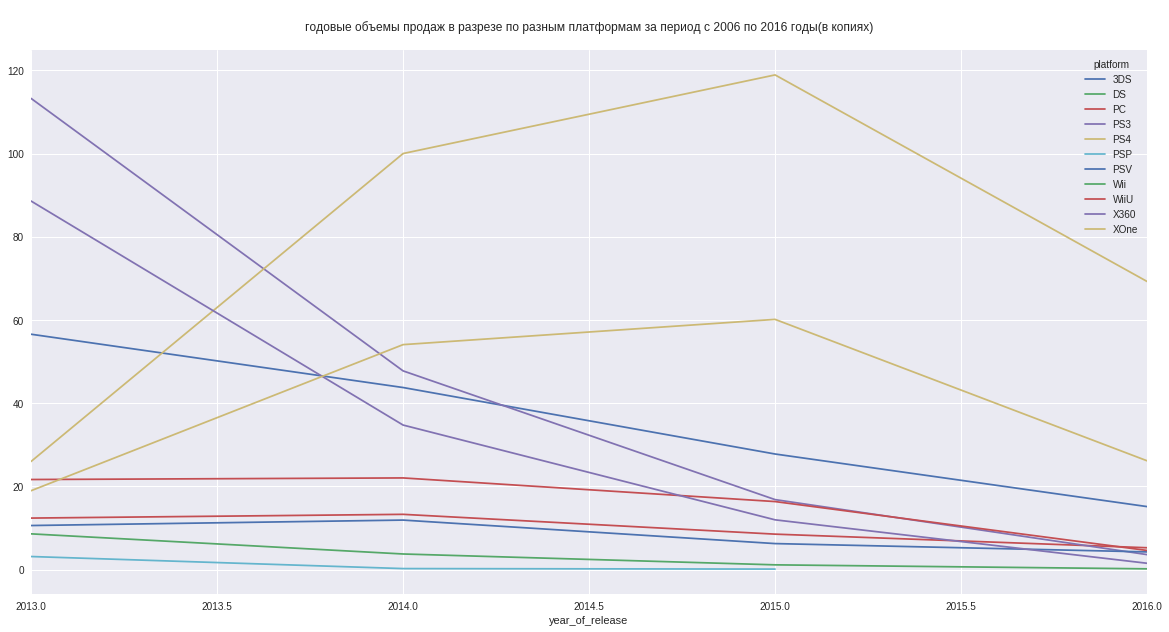

In [24]:
(
    (
    df_fresh
     .pivot_table(
                 index = 'year_of_release',
                 columns = 'platform',
                 values = 'global_sales',
                 aggfunc = 'sum'
                 )
    )
    .plot(figsize = (20, 10), grid = True)
)
plt.title("\n" + 'годовые объемы продаж в разрезе по разным платформам за период с 2006 по 2016 годы(в копиях)' + "\n")
plt.show()

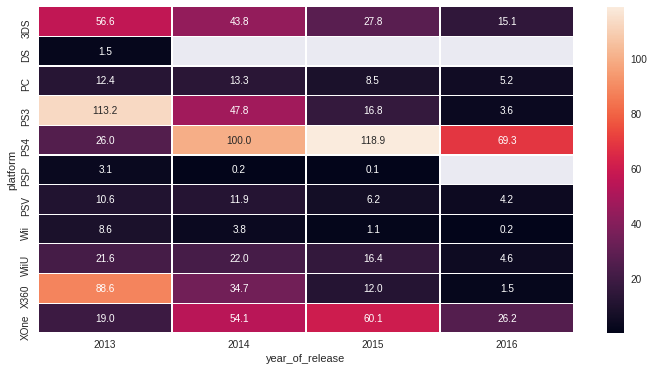

In [25]:
# для удобства построим тепловую карту
# чем темнее сегмент карты, тем меньше продаж было у платформы в определенном году

platform_sales = df_fresh.pivot_table(
                 index = 'year_of_release',
                 columns = 'platform',
                 values = 'global_sales',
                 aggfunc = 'sum').T

plt.figure(figsize = (12, 6))
sns.heatmap(platform_sales, annot=True, fmt=".1f", linewidths=.3)
plt.show()

Единственные платформы, у которых заметен *значительный* рост это PS4 и Xbox One. <br>
С конца 2013 года объем продаж игр на этих двух платформах превышает объемы продаж у любой другой платформы.<br>
Падение объема продаж в 2015 году не должно нас смущать: до конца 7-летнего жизненного цикла еще целых 4 года, а значит пик продаж еще не пройден.

Другие платформы либо стагнируют, либо теряют объемы продаж.

**Итого: потенциально прибыльными платформами будем считать PS4, Xbox One.**
***

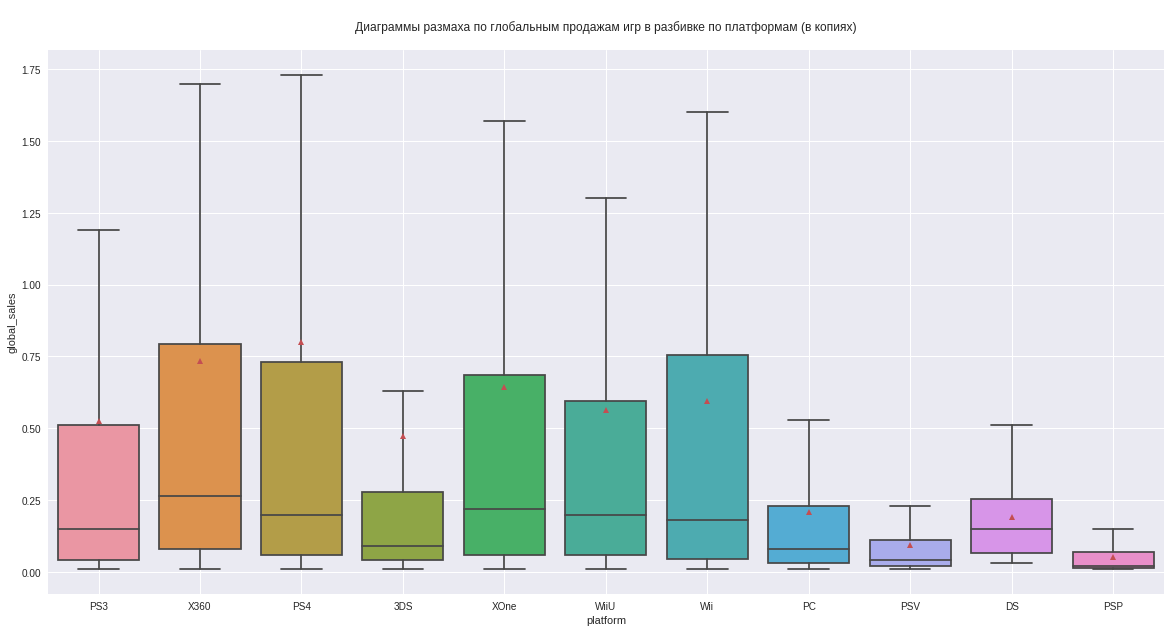

In [26]:
plt.figure(figsize = (20, 10))
sns.boxplot(
            x = 'platform',
            y = 'global_sales',
            data = df_fresh,
            showfliers = False,
            showmeans = True
            )
plt.title("\n" + 'Диаграммы размаха по глобальным продажам игр в разбивке по платформам (в копиях)'+ "\n")
plt.grid(True)
plt.show()

Практически у всех платформ, кроме Xbox 360 медианное кол-во проданных копий игры не превышает 250 тысяч. <br>
При этом у каждой платформы мы видим, что распределения скошены вправо (вверх) и что есть длинные "усы". <br>
Это значит, что ровно у половины всех игр на этих платформах объемы продаж значительно выше, чем медианное значение по платформе. Скорее всего такой разброс связан с тем, что на каждой платформе бывают свои "хиты", которые хорошо продаются. <br>

Особенно это заметно у Xbox, PS и Wii старого и нового поколений. <br>
Именно на этих платформах мы видим, что половина всех игр продаются в объеме от 150-230 до 760 тысяч копий, а так же что есть длинные хвосты — игры хиты, которые расходятся тиражом от 1 до нескольких миллионов копий копий. <br>

Игры для PS4 и XboxOne обычно стоят дороже, чем игры для других платформ и половина этих игр расходится большими тиражами. <br>
Компания получит больше прибыли, если сосредоточит усилия на продаже игр именно для этих платформ.

#### Изучаем влияние оценок пользователей и критиков на продажи игр популярных платформ


Матрица корреляции глобальных объемов продаж и оценок



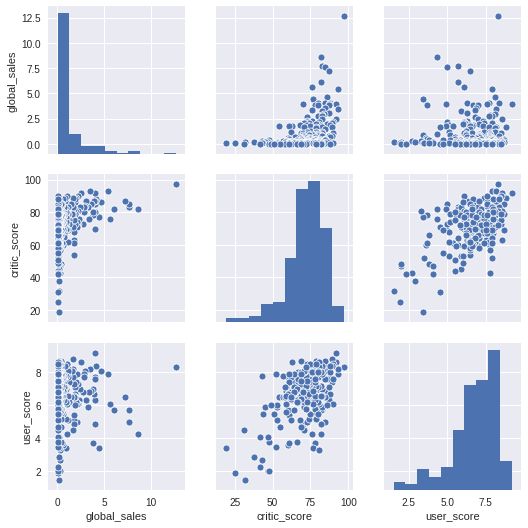

In [27]:
# Изучим, как оценки пользователей и критиков влияют на продажи игр для PS4
cols = ['global_sales', 'critic_score','user_score']
print("\n" + 'Матрица корреляции глобальных объемов продаж и оценок' + "\n")
sns.pairplot(df_fresh.query('~user_score.isna() & ~critic_score.isna() & platform == "PS4"')[cols])
plt.show()

global_sales    1.00
critic_score    0.41
user_score     -0.03
Name: global_sales, dtype: float64

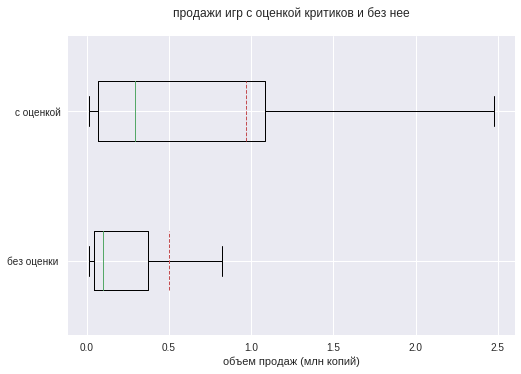

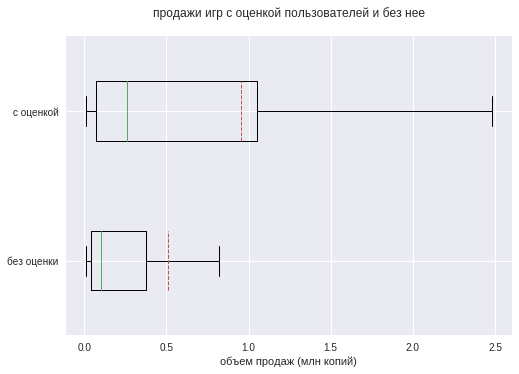

In [28]:
# посмотрим на коэффициент корреляции для PS4
display(df_fresh.query('~user_score.isna() & ~critic_score.isna() & platform == "PS4"')
 [['global_sales', 'critic_score', 'user_score']]
 .corr()['global_sales']
 .sort_values(ascending = False)
)

plt.boxplot([df_fresh.query('platform == "PS4" and critic_score.isna()')['global_sales'],
                   df_fresh.query('platform == "PS4" and ~critic_score.isna()')['global_sales']],
                   labels = ['без оценки ', 'с оценкой'],
                    showfliers = False,
                    meanline = True,
                    showmeans = True,
                    autorange = True,
                    vert = False,
                    widths = 0.4
                  )

plt.title('продажи игр с оценкой критиков и без нее'+ "\n")
plt.xlabel('объем продаж (млн копий)')
plt.show()

print()

plt.boxplot([df_fresh.query('platform == "PS4" and user_score.isna()')['global_sales'],
                   df_fresh.query('platform == "PS4" and ~user_score.isna()')['global_sales']],
                   labels = ['без оценки', 'с оценкой'],
                    showfliers = False,
                    meanline = True,
                    showmeans = True,
                    autorange = True,
                    vert = False,
                    widths = 0.4
                  )
plt.title('продажи игр с оценкой пользователей и без нее'+ "\n")
plt.xlabel('объем продаж (млн копий)')
plt.show()

На платформе PS4 между глобальными продажами и оценкой критиков есть слабая взаимосвязь: в некоторых случаях у игр с высокой оценкой критиков больше продаж. <br>
Возможно, есть сегмент игроков, которые следят за оценками критиков и покупают игры только если критики ставят высокие оценки. <br>
Также вероятно, что есть несколько других факторов, которые влияют на уровень продах игр с высокой оценкой: игры от известных студий, долгожданные "игры шедевры", мощные маркетинговые кампании и т.д. <br>

Стоит также заметить, что игры без оценок продаются гораздо хуже. Возможно это малоизвестные игры.

global_sales    1.00
critic_score    0.41
user_score     -0.09
Name: global_sales, dtype: float64

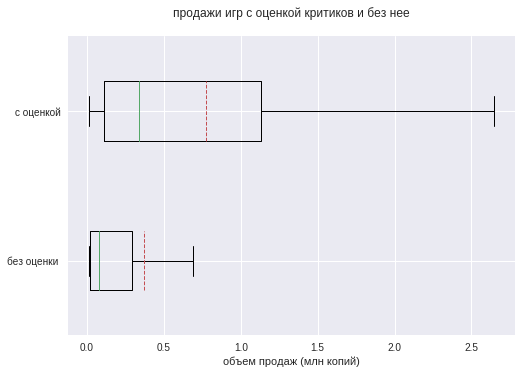

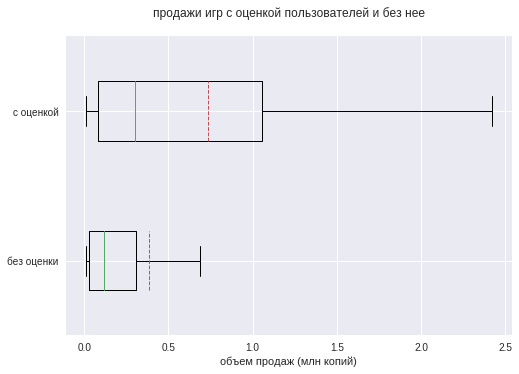

In [29]:
# посмотрим на коэффициент корреляции для Xbox One
display(df_fresh.query('~user_score.isna() & ~critic_score.isna() & platform == "XOne"')
 [['global_sales', 'critic_score', 'user_score']]
 .corr()['global_sales']
        
 .sort_values(ascending = False)
)

plt.boxplot([df_fresh.query('platform == "XOne" and critic_score.isna()')['global_sales'],
                   df_fresh.query('platform == "XOne" and ~critic_score.isna()')['global_sales']],
                   labels = ['без оценки ', 'с оценкой'],
                    showfliers = False,
                    meanline = True,
                    showmeans = True,
                    autorange = True,
                    vert = False,
                    widths = 0.4
                  )
plt.title('продажи игр с оценкой критиков и без нее'+ "\n")
plt.xlabel('объем продаж (млн копий)')
plt.show()

print()

plt.boxplot([df_fresh.query('platform == "XOne" and user_score.isna()')['global_sales'],
                   df_fresh.query('platform == "XOne" and ~user_score.isna()')['global_sales']],
                   labels = ['без оценки', 'с оценкой'],
                    showfliers = False,
                    meanline = True,
                    showmeans = True,
                    autorange = True,
                    vert = False,
                    widths = 0.4
                  )
plt.title('продажи игр с оценкой пользователей и без нее'+ "\n")
plt.xlabel('объем продаж (млн копий)')
plt.show()

Как и на PS4, оценки пользователей не влияют на продажи игр, но важно само их наличие (скорее всего здесь есть та же самая связь с неизвестными факторами). <br>
На Xbox One оценки критиков влияют на продажи игр также, как и на PS4. <br>
<br>
На обеих платформах у игр без каких-либо оценок объем продаж обычно меньше, чем у игр с оценками.

#### Изучаем продажи в разрезе жанров

In [30]:
# создадим таблицу с общей суммой продаж и кол-вом выпущенных игр в разрезе по жанрам

df_genres_data = df_fresh.groupby('genre').agg({'global_sales':['sum', 'count']})
df_genres_data.columns = ['total_sales', 'games_released']
df_genres_data = df_genres_data.sort_values(by = 'total_sales', ascending = False)
df_genres_data

,total_sales,games_released
genre,,
Action,321.87,766
Shooter,232.98,187
Sports,150.65,214
Role-Playing,145.89,292
Misc,62.82,155
Platform,42.63,74
Racing,39.89,85
Fighting,35.31,80
Adventure,23.64,245


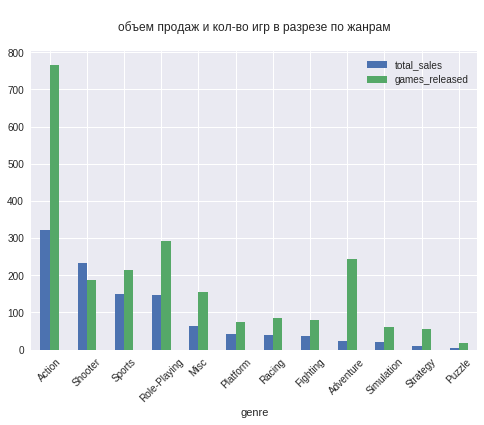

In [31]:
# построим совместный график

df_genres_data.plot(kind = 'bar', rot = 45)
plt.title("\n" + 'объем продаж и кол-во игр в разрезе по жанрам'+ "\n")
figsize = (20,10)
plt.show()

#df_genres_data.corr()

Самый популярный жанр игр — Action: с 2006 по 2016 год родано более миллиарда копий игр этого жанра. Также за этот период выпустили больше всего игр именно в этом жанре. <br>
Далее следуют жанры Sports и Shooter: продано чуть больше 700 млн копий. <br>
Остальные жанры менее популярны: объем продаж игр в этих жанрах не превышает 600 млн копий за весь период. 

К менее популярным играм можно отнести игры в жанре Misc и Role-Playing.

К наименее популярным: Racing, Platform, Simulation и Fighting.

Совсем непопулярны игры в жанрах Adventure, Puzzle и Strategy.

Однако, следует заметить, что производители игр тоже ориентируются на тренды и скорее всего малый объем продаж игр в некоторых жанрах связан с тем, что игр в таких жанрах в принципе мало на рынке.

Далее изучим разброс этих данных.

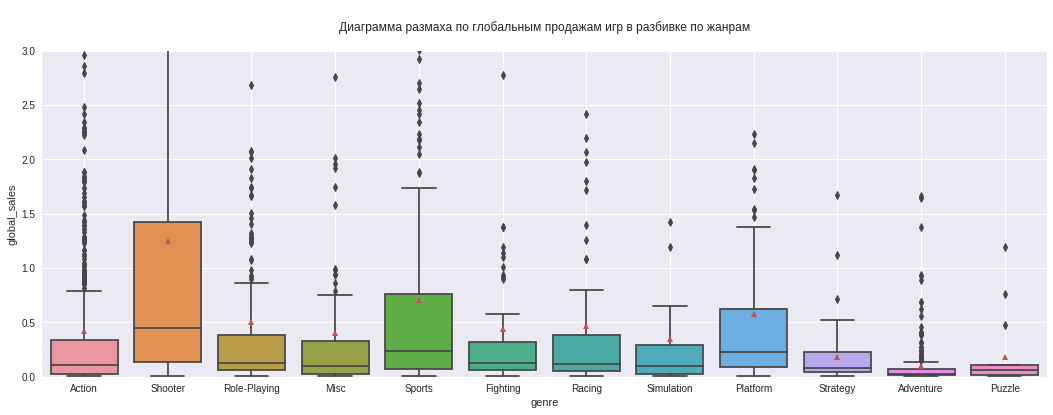

In [32]:
plt.figure(figsize = (18, 6))
sns.boxplot(
            x = 'genre',
            y = 'global_sales',
            data = df_fresh,
            showfliers = True,
            showmeans = True
            )
plt.title("\n" + 'Диаграмма размаха по глобальным продажам игр в разбивке по жанрам'+ "\n")
plt.grid(True)
plt.ylim(0, 3)
plt.show()

Хотя по объемам продаж лидирует жанр Action, его распределение гораздо скромнее, чем распределение объемов продаж в жанре Shooter и чуть скромнее, чем у жанра Sports.

Лидерство жанра Action в продажах можно объяснить тем, что в этом жанре выпускается больше всего игр и общий объем продаж жанра складывается из продаж множества разных игр.

По медиане и среднему значению видно, что средняя игра в жанре Action расходится меньшим тиражом, нежели игры в жанрах Shooter и Sports. <br>
Также средняя игра жанра Platform тоже продается лучше, чем средняя игра жанра Action.

Жанр Shooter самый разнообразный с точки зрения объемов продаж: игры могут продаваться и тиражом 800 тысяч копий и более 3 млн.

**Итого: успешными жанрами игр можно считать спортивные игры, платформеры, экшн и шутеры.**

## Шаг 4. Портреты пользователей в разных регионах <a id="Шаг_4"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion4)

Для пользователей каждого региона (NA, EU, JP):
- [x] Определить топ-5 популярных платформ и описать различия в долях продаж
- [x] Определить топ-5 жанров и объяснить разницу
- [x] Определить, влияет ли рейтинг ESRB на продажи в отдельном регионе

In [33]:
# напишем функцию для получения удобной для сравнения таблицы с топ-5 чего-угодно в разных регионах

# на входе функция будет получать:
# - название столбца, по которому нужно получить топ
# - название финальной таблицы для вывода
# - длину таблицы (вдруг захочется получить топ-10)

def get_top(column, final_table_name, table_len):
    
    # создадим простой датафрейм, к которому присоединим все таблицы
    final_table_name = pd.DataFrame(np.random.randn(9, 1), columns=list('A'))
    final_table_name = final_table_name.drop('A', axis = 1)

    # cохраним список регионов, к которому будем обращаться в цикле
    regions = ['na_sales', 'eu_sales', 'jp_sales']

# через цикл сделаем группировку по платформам для каждого региона и соединим их в общую таблицу
    for region in regions:
        table = (
                    df_fresh.groupby(by = column)[[column, region]]
                    .sum()
                    .sort_values(by = region, ascending = False)
                    .reset_index()
                    )
        table['share'] = table[region] / table[region].sum()
        table[''] = '|'
        final_table_name = (final_table_name
                                            .merge(table,
                                                   left_index=True,
                                                   right_index=True))

# для удобства переименуем строки
# так как таблица нужна только для наглядного сравнения, строки назовем так, чтобы таблицу было легче воспринимат
    final_table_name.set_axis(['NA_top',
                                 'NA_sales',
                                 'NA_market_%',
                                  '/',
                                 'EU_top',
                                 'EU_sales',
                                 'EU_market_%',
                                  '|',
                                 'JP_top',
                                 'JP_sales',
                                 'JP_market_%',
                                  '\\'
                               ],
                                 axis = 'columns',
                                 inplace = True
                               )
    


# отобразим полученную таблицу
    return (final_table_name
                            .head(table_len)
                            .style
                            .format({'NA_market_%':'{:.2%}'})
                            .format({'EU_market_%':'{:.2%}'})
                            .format({'JP_market_%':'{:.2%}'})
                            .bar(subset=['NA_sales', 'EU_sales', 'JP_sales'], color='#d65f5f')
                            .bar(subset=['NA_market_%', 'EU_market_%', 'JP_market_%'], color='#d69f8f')
           )


# да, это жестко.

### Топ-5 популярных платформ

In [34]:
print()
print('Топ-5 платформ по объемам продаж игр в трех регионах')
get_top('platform', 'reg_top_platform', 5)


Топ-5 платформ по объемам продаж игр в трех регионах


,NA_top,NA_sales,NA_market_%,/,EU_top,EU_sales,EU_market_%,|,JP_top,JP_sales,JP_market_%,\
0,PS4,108.74,24.84%,|,PS4,141.09,35.97%,|,3DS,67.81,48.17%,|
1,XOne,93.12,21.27%,|,PS3,67.81,17.29%,|,PS3,23.35,16.59%,|
2,X360,81.66,18.66%,|,XOne,51.59,13.15%,|,PSV,18.59,13.21%,|
3,PS3,63.5,14.51%,|,X360,42.52,10.84%,|,PS4,15.96,11.34%,|
4,3DS,38.2,8.73%,|,3DS,30.96,7.89%,|,WiiU,10.88,7.73%,|


В Северной Америке и в Европе самые популярные платформы практически одни и те же. <br>
Однако популярность внутри группы разная. <br>

В Америке популярны PS4, Xbox One и Xbox 360 (видимо, доживающий свой век). Xbox занимала 40% всего рынка (и это его родной рынок), PS4 только четверть.<br>
В Европе популярны эти же платформы, но в ином порядке: PS4, PS3, Xbox One и 360. Xbox здесь менее популярен и занимает меньше четверти рынка. Европейцы предпочитают играть на Playstation, которая занимала половину всего рынка в 2013-2016 годах.

В Японии не нашлось места Xbox: здесь популярны только местные платформы. Примечательно, что лидируют портативная платформа 3DS. Вместе с PSV они занимают более половины рынка. Японцы любят играть "находу"?. PS3 в этот период все еще популярнее PS4.

### Топ-5 жанров

In [35]:
print()
print('Топ-5 жанров по объемам продаж игр в трех регионах')
get_top('genre', 'reg_top_genres', 5)


Топ-5 жанров по объемам продаж игр в трех регионах


,NA_top,NA_sales,NA_market_%,/,EU_top,EU_sales,EU_market_%,|,JP_top,JP_sales,JP_market_%,\
0,Action,126.05,28.80%,|,Action,118.13,30.12%,|,Role-Playing,51.04,36.26%,|
1,Shooter,109.74,25.07%,|,Shooter,87.86,22.40%,|,Action,40.49,28.76%,|
2,Sports,65.27,14.91%,|,Sports,60.52,15.43%,|,Misc,9.2,6.54%,|
3,Role-Playing,46.4,10.60%,|,Role-Playing,36.97,9.43%,|,Fighting,7.65,5.43%,|
4,Misc,27.49,6.28%,|,Racing,20.19,5.15%,|,Shooter,6.61,4.70%,|


В Европе и Америке топ жанров выглядит практически одинаково: игры в жанре Action самые популярные, после них идут спортивные игры а далее шутеры. <br>
Также в Европе жанр гонки популярнее, чем в Америке. <br>

В Японии треть рынка занимают ролевые игры. Популярность ролевых игр в Японии — это известный в индустрии культурный феномен. <br>
Также вероятно, что среди игр для портативных платформ очень много разных ролевых игр. <br>
Примечательно, что "стрелялки" малопопулярны в Японии и больше здесь любят файтинги (хотя и у них очень малая доля рынка).

### Влияние рейтинга ESRB на продажи

In [36]:
print()
print('Топ-5 рейтингов по объемам продаж игр в трех регионах')
get_top('rating', 'top_ratings', 10)


Топ-5 рейтингов по объемам продаж игр в трех регионах


,NA_top,NA_sales,NA_market_%,/,EU_top,EU_sales,EU_market_%,|,JP_top,JP_sales,JP_market_%,\
0,M,165.21,37.74%,|,M,145.32,37.05%,|,ND,85.05,60.41%,|
1,ND,89.42,20.43%,|,E,83.36,21.25%,|,T,20.59,14.63%,|
2,E,79.05,18.06%,|,ND,78.91,20.12%,|,E,15.14,10.75%,|
3,E10+,54.24,12.39%,|,E10+,42.69,10.88%,|,M,14.11,10.02%,|
4,T,49.79,11.38%,|,T,41.95,10.70%,|,E10+,5.89,4.18%,|


В Европе и Америке в период с 2013 по 2016 год лучше всего продавались игры с рейтингом M "старше 17 лет" E "для всех". <br>
Доля игр с такими рейтингами составляет чуть более половины от рынков этих стран. <br>
Также в обоих регионах 20% рынка за этот период составлили игры без рейтинга (ND). Вероятно при выгрузке данных возникли какие-то проблемы, так как игры не могут продаваться без возрастного рейтинга.

В Японии за этот период более чем у половины всех игр не указан рейтинг. <br>
Вероятнее всего это связано с тем, что оценкой большинства игр для японского рынка занимается организация "CERO" ("Computer Entertainment Rating Organization"), у которой своя система рейтинга. Оценок по системе CERO нет в нашей таблице. <br>
Также возможно присутствие той же проблемы с выгрузкой данных.

Игры "для всех" в Японии занимают меньшую долю рынку, чем в других регионах — всего 10%. <br>
Примечательно, что игры с рейтингом Т "старше 13 лет" в Японии популярнее, чем игры с рейтингом "старше 17 лет" и "для всех". <br>
Возможно, возрастной состав игроков в разных регионах различается, либо стратегия разработчиков игр для портативных платформ заключается в максимальном охвате подростковой аудитории. Также это может означать, что хорошие и популярные игры не обязательно должны содержать контент для взрослых. Но из данных нам это не известно.

### Выводы <a id="conclusion4"></a>
[В начало шага](#Шаг_4)

**Средний пользователь северной Америки и Европы:**  предпочитает игры в жанрах action, shooter & sports, играет на платформах Xbox 360, Xbox One, PS3 и PS4 в игры с возрастным рейтингами "старше 17 лет" и "для всех".

**Средний пользователь северной Японии:**  предпочитает игры в жанрах role-playing и action на платформах 3DS, PS3 и PSV.

Учитывая топ-платформ в каждом регионе, можно заключить, что платформы следующих поколений от тех же производителей тоже будут в топе в период с 2014 по 2020 год.

Рейтинг в каждом регионе влияет на продажи: лучше всего продаются игры для всех, а игры с возрастными ограничениями продаются в меньших объемах, так как у них более узкий сегмент потребителей.
***

## Шаг 5. Проверка гипотез <a id="Шаг_5"></a>

[В начало проекта](#начало)

<br>
Для проверки гипотез будем использовать метод сравнения двух выборочных средних (t-test) и критерий p-value. <br>
P-value — это вероятность получить исход события совершенно случайно при условии, что нулевая гипотеза верна. <br>
Если это значение ниже выбранного уровня значимости, то вероятность получить такой исход случайно при истинности нулевой гипотезы крайне мала, а значит такой исход не случаен и нулевую гипотезу можно отвергнуть, т.к. она не может быть истинной.<br>

Уровнем статистической значимости теста выберем 5% или 0.05. <br>
Значит, если p-value будет ниже этого уровня, мы сможем отвергнуть нулевую гипотезу и наоборот.

In [37]:
# Напишем функцию, которая будет строить распределение нужных семплов и проводить статистический тест

def checkHypothesis(s1, s2, alpha=.05):
    
    # выведем среднее значение по выборке и распределение значений на экран
    def makeHist(x):
        avg = np.round(x.mean(), 2)
        
        plt.hist(x)
        plt.title("\n" + x.name + ' ' + str(avg) + "\n")
        plt.show()
    
    makeHist(s1)
    makeHist(s2)
    
    # добавим в функцию расчет разницы дисперсии. Если дисперсии различаются больше чем на 5%, т-тест будет это учитывать
    sample1_var = sample_1.var()
    sample2_var = sample_2.var()
    std_diff = abs(sample1_var/sample2_var - 1)
    eq_var = std_diff <= .05
    
    # проведем сам т-тест
    results = st.ttest_ind(s1, s2, equal_var = eq_var)
    
    # выведем результат
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу, так как различия статистически значимы')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу')

### Проверяем гипотезу о разнице средних пользовательских рейтингов на Xbox One и PC

**Нулевая гипотеза:** cредние пользовательские рейтинги платформ Xbox One и PC одинаковые <br>
**Альтернативная гипотеза:** cредние пользовательские рейтинги платформ Xbox One и PC различаются

In [38]:
# изучим средние оценки на разных платформах

(
    df_fresh
    .query('platform.isin(["XOne", "PC"])')
    .groupby('platform')
    .agg(
            cnt = ('user_score', 'count'), 
            mean_score = ('user_score', 'mean'),
            score_std = ('user_score', 'std')
    )
)

,cnt,mean_score,score_std
platform,,,
PC,155,6.27,1.74
XOne,182,6.52,1.38


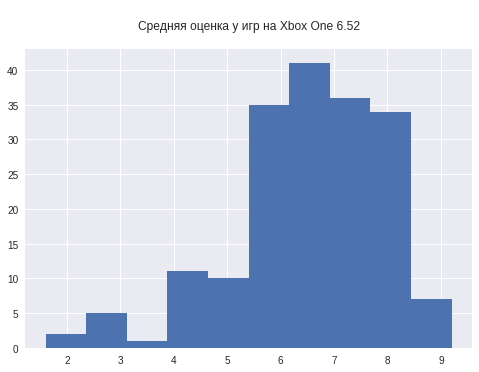

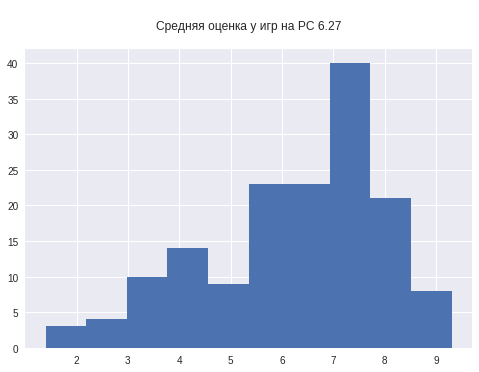

p-значение:  0.14759594013430463
Нет оснований отвергнуть нулевую гипотезу


In [39]:
# создадим нужные семплы и дадим им имена
sample_1 = df_fresh.query('~user_score.isna() & platform == "XOne"').user_score
sample_1.name = 'Средняя оценка у игр на Xbox One'
sample_2 = df_fresh.query('~user_score.isna() & platform == "PC"').user_score
sample_2.name = 'Средняя оценка у игр на PC'

# построим графики распределения и проведем т-теста
checkHypothesis(sample_1, sample_2)

Средние пользовательские рейтинги у разных платформ не различаются,
так как значение p-value указывает на то, что есть 14% вероятность получить такую разницу случайно. <br>

### Проверяем гипотезу о разнице средних пользовательских рейтингов у жанров Action и Sports

**Нулевая гипотеза:** cредние пользовательские рейтинги жанров Action и Sports одинаковые <br>
**Альтернативная гипотеза:** cредние пользовательские рейтинги жанров Actions и Sports различаются

In [40]:
# изучим средние оценки у разных жанров
(
    df_fresh
    .query('genre.isin(["Action", "Sports"])')
    .groupby('genre')
    .agg(
            cnt = ('user_score', 'count'), 
            mean_score = ('user_score', 'mean'), 
            score_std = ('user_score', 'std')
    )
)

,cnt,mean_score,score_std
genre,,,
Action,389,6.84,1.33
Sports,160,5.24,1.78


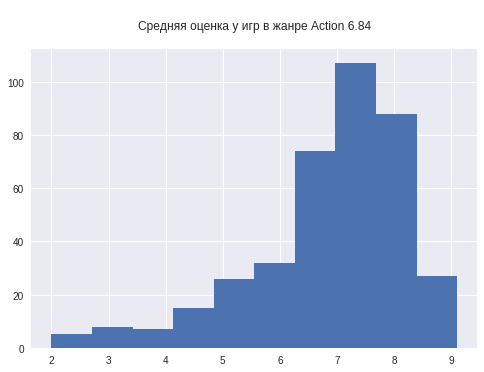

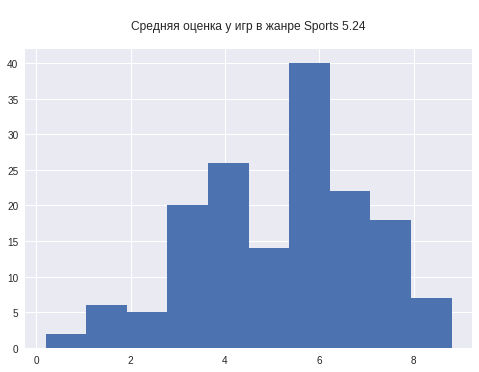

p-значение:  1.4460039700704315e-20
Отвергаем нулевую гипотезу, так как различия статистически значимы


In [41]:
sample_1 = df_fresh.query('~user_score.isna() & genre == "Action"').user_score
sample_1.name = 'Средняя оценка у игр в жанре Action'
sample_2 = df_fresh.query('~user_score.isna() & genre == "Sports"').user_score
sample_2.name = 'Средняя оценка у игр в жанре Sports'

checkHypothesis(sample_1, sample_2)

Принимаем альтернативную гипотезу: в среднем оценки у игр жанра Action выше, чем у жанра Sports. <br>

### Выводы <a id="conclusion5"></a>
[В начало шага](#Шаг_5)

Пользователи PC и пользователи Xbox One одинаково оценивают игры.

Средние пользовательские оценки у жанров Action и Sports обычно различаются: экшн-игры обычно оценивают выше.


## Шаг 6. Результаты исследования <a id="Шаг_6"></a>

[В начало проекта](#начало)

Потенциально популярными играми в следующем году будут игры, выпущенные на платформах PS4 и Xbox One в жанрах Action, Shooter и Sports c возрастными рейтингами "для всех" и "от 17 лет". Такие игры следует рекламировать на западном рынке.

В Японии популярными играми будут игры в жанре Role-Playing и Action на портативной платформе 3DS и PSV c возрастным рейтингом (ESRB) "для всех" и "от 13 лет"

Также следует учитывать, что игры без оценок пользователей и критиков будут продаваться хуже и на них не стоит тратить ресурсы.
Для тех игр, у которых есть оценки, не стоит учитывать оценки пользователей, так как значение этих оценок не влияет на продажи (только их наличие). <br>

В некоторых случаях оценки критиков влияют на объем продаж игры, поэтому их тоже следует учитывать. Оценки критиков важно использовать в маркетинговой коммуникации для долгожданных игр-хитов, так как именно такие игры собирают множество положительных оценок критиков и тем сам привлекают к себе внимание игроков.

Заказчику стоит сосредоточить бюджет на продвижении игр с указанными характеристиками, чтобы максимизировать прибыль в 2017 году.